In [8]:
import pandas as pd 
import numpy as np 
pd.set_option('display.max_columns',None)

In [11]:
data = pd.read_csv(r'data/门店月数据.csv',encoding='gbk')

In [14]:
data['复购人数'] = data['下单人数'] - data['下单新客人数']

In [18]:
rfm = data.groupby(['开始日期','商家ID','商家名称'],as_index=False).agg({'（日均）在线营业时长（h）': 'sum','下单人数':'sum', '实付交易额': 'sum'  })

In [19]:
rfm.columns = ['time','商家ID','商家名称','r','f','m']



In [21]:
rfm.head()

,time,商家ID,商家名称,r,f,m
0,20200901,227035,邂逅花坊鲜花（香梅花坊）,15.1,8,1116.00
1,20200901,255297,邂逅花坊鲜花（蔷薇花艺）,15.0,10,931.00
2,20200901,345331,邂逅花坊鲜花（温馨花坊）,17.6,31,3540.80
3,20200901,403721,邂逅花坊鲜花（创懿花艺婚庆）,14.6,12,1292.49
4,20200901,634577,邂逅花坊鲜花（花韵千谷),13.3,12,1265.00


In [22]:
desc_pd = rfm.iloc[:,2:].describe().T

In [23]:
desc_pd = desc_pd[['min','50%','75%','max']]
desc_pd

,min,50%,75%,max
r,0.0,14.4,15.300,24.0
f,0.0,7.0,17.000,264.0
m,0.0,793.5,2044.895,34376.7


In [24]:
r_bins = [-1,14.4,15.3,24]
f_bins = [-1,7,17,264]
m_bins = [-1,793.5,2044.895,34376.7]

In [25]:
from sklearn.ensemble import RandomForestClassifier # RF库
clf = RandomForestClassifier()

In [26]:
rfm_merge = pd.merge(rfm,data,on='商家ID',how='inner')

In [33]:
print(rfm_merge['有效订单数'].quantile(0.2))
print(rfm_merge['有效订单数'].quantile(0.4))
print(rfm_merge['有效订单数'].quantile(0.6))
print(rfm_merge['有效订单数'].quantile(0.8))
print(rfm_merge['有效订单数'].quantile(1))

1.0
4.0
10.0
20.0
294.0


In [39]:
def fun(x):
    if 20<x <= 294:
        return 5
    elif 10<x <= 20:
        return 4
    elif 4<x <= 10:
        return 3
    elif 1<x <= 4:
        return 2
    elif 0<= x <= 1:
        return 1
rfm_merge['cluster']= rfm_merge['有效订单数'].apply(lambda x: fun(x))

In [42]:
clf = clf.fit(rfm_merge[['r','f','m']],rfm_merge['cluster'])
weights = clf.feature_importances_
print('feature importance:',weights)

feature importance: [0.10001823 0.4347476  0.46523416]


In [43]:
# RFM分箱得分
rfm['r_score'] = pd.cut(rfm['r'], r_bins, labels=[i+1 for i in range(len(r_bins)-1)])  # 计算R得分
rfm['f_score'] = pd.cut(rfm['f'], f_bins, labels=[i+1 for i in range(len(f_bins)-1)])  # 计算F得分
rfm['m_score'] = pd.cut(rfm['m'], m_bins, labels=[i+1 for i in range(len(m_bins)-1)])  # 计算M得分

In [45]:
rfm

,time,商家ID,商家名称,r,f,m,r_score,f_score,m_score
0,20200901,227035,邂逅花坊鲜花（香梅花坊）,15.1,8,1116.00,2,2,2
1,20200901,255297,邂逅花坊鲜花（蔷薇花艺）,15.0,10,931.00,2,2,2
2,20200901,345331,邂逅花坊鲜花（温馨花坊）,17.6,31,3540.80,3,3,3
3,20200901,403721,邂逅花坊鲜花（创懿花艺婚庆）,14.6,12,1292.49,2,2,2
4,20200901,634577,邂逅花坊鲜花（花韵千谷),13.3,12,1265.00,1,2,2
...,...,...,...,...,...,...,...,...,...
2154,20200901,10070283,情侣花卉（生日花，表白花，鲜花）,12.3,0,0.00,1,1,1
2155,20200901,10078548,花语堂（生日花，表白花，鲜花）,12.2,0,0.00,1,1,1
2156,20200901,10080207,禾朵花艺（生日花，表白花，鲜花）,19.1,0,0.00,3,1,1
2157,20200901,10096335,星语花屋,7.9,0,0.00,1,1,1


In [46]:
# 方法二：RFM组合
rfm['r_score'] = rfm['r_score'].astype(np.str)
rfm['f_score'] = rfm['f_score'].astype(np.str)
rfm['m_score'] = rfm['m_score'].astype(np.str)
rfm['rfm_group'] = rfm['r_score'].str.cat(rfm['f_score']).str.cat(rfm['m_score'])

In [47]:
rfm.to_csv('rfm.csv') 

In [52]:
rfm_merge[rfm_merge['商家ID'] == 5444851]

,time,商家ID,商家名称_x,r,f,m,开始日期,结束日期,商家名称_y,运营组,省份,城市,是否新增商家,首次上线日期,门店在线状态,（日均）预设营业时长（h）,（日均）在线营业时长（h）,曝光人数,入店人数,下单人数,下单新客人数,入店转化率,下单转化率,推单数,有效订单数,原价交易额,实付交易额,商家补贴金额,商家原因取消订单数,商家拒单数,商家超时未接单数,商家取消不告知用户订单数,缺货导致退款订单数,商家少送错送导致用户退款订单数,商家质量问题导致用户退款订单数,配送原因取消订单数,拣货超时订单数,使用间或完成按钮订单数,平均骑手到店等待时间（min）,平均骑手送货时长（min）,IM会话数,IM回复数,IM回复率,IM1分钟回复数,差评订单数,投诉订单数,平均商家评分,平均商品评分,平均配送评分,平均配送时长（min）,资质类型（仅药品）,资质有效期（仅药品）,复购人数,cluster
372,20200901,5444851,邂逅花坊鲜花（雅馨花坊）,16.8,9,1323.7,20200901,20200930,邂逅花坊鲜花（雅馨花坊）,鲜花组,湖南省,株洲,否,20180715,在线,17.0,16.8,4007,191,9,5,4.77,4.71%,12,12,3382.0,1323.7,2058.3,0,0,0,0,0,0,0,0,0,12,0,0,6,6,100.0,4,0,0,4.8,4.8,5.0,0.0,NaN,NaN,4,4


In [53]:
rfm_hist = pd.read_csv('disdata.csv')

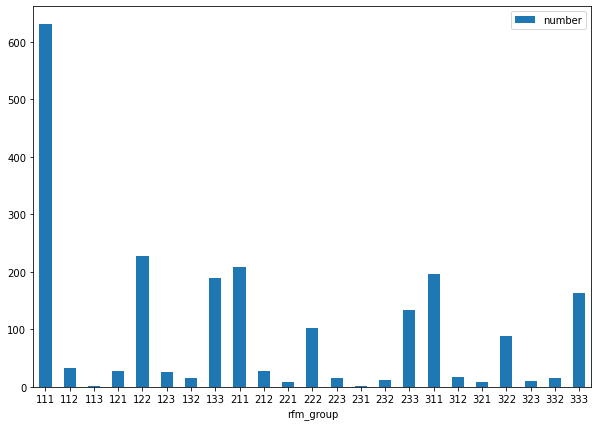

In [66]:
rfm_hist.plot.bar( x='rfm_group', y='number',rot=0,figsize=[10,7])
